# Sliding Window & Pipeline Experiments
This Notebook is basically a set of experiments for the real detection pipeline. Concretely it uses some test images to experiment and visualize with the sliding window computation strategy, and experiments for finding a suteable threshold for the headmap.

## Helper functions
A set of functions needed for the rest. Ususally I move that into a own python file later and include it ihere, or move it to the bottom...

In [8]:
import numpy as np
import cv2

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    def cond_set(val, default):
        return val if val is not None else default
    
    x_start_stop[0] = cond_set(x_start_stop[0], 0)
    x_start_stop[1] = cond_set(x_start_stop[1], img.shape[1])
    
    y_start_stop[0] = cond_set(y_start_stop[0], 0)
    y_start_stop[1] = cond_set(y_start_stop[1], img.shape[0])
    
    span = (x_start_stop[1]-x_start_stop[0], y_start_stop[1] - y_start_stop[0])
    step = (int(xy_window[0]*xy_overlap[0]), int(xy_window[1]*xy_overlap[1]))
    shape = (np.int((span[0]-step[0])/step[0]), np.int((span[1]-step[1])/step[1]))
    num = shape[0]*shape[1]
    #print("debug: ", x_start_stop, y_start_stop, span, step, shape, num)
    window_list = []
    for ys in range(shape[1]):
        for xs in range(shape[0]):
            startx = xs*step[0] + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*step[1] + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

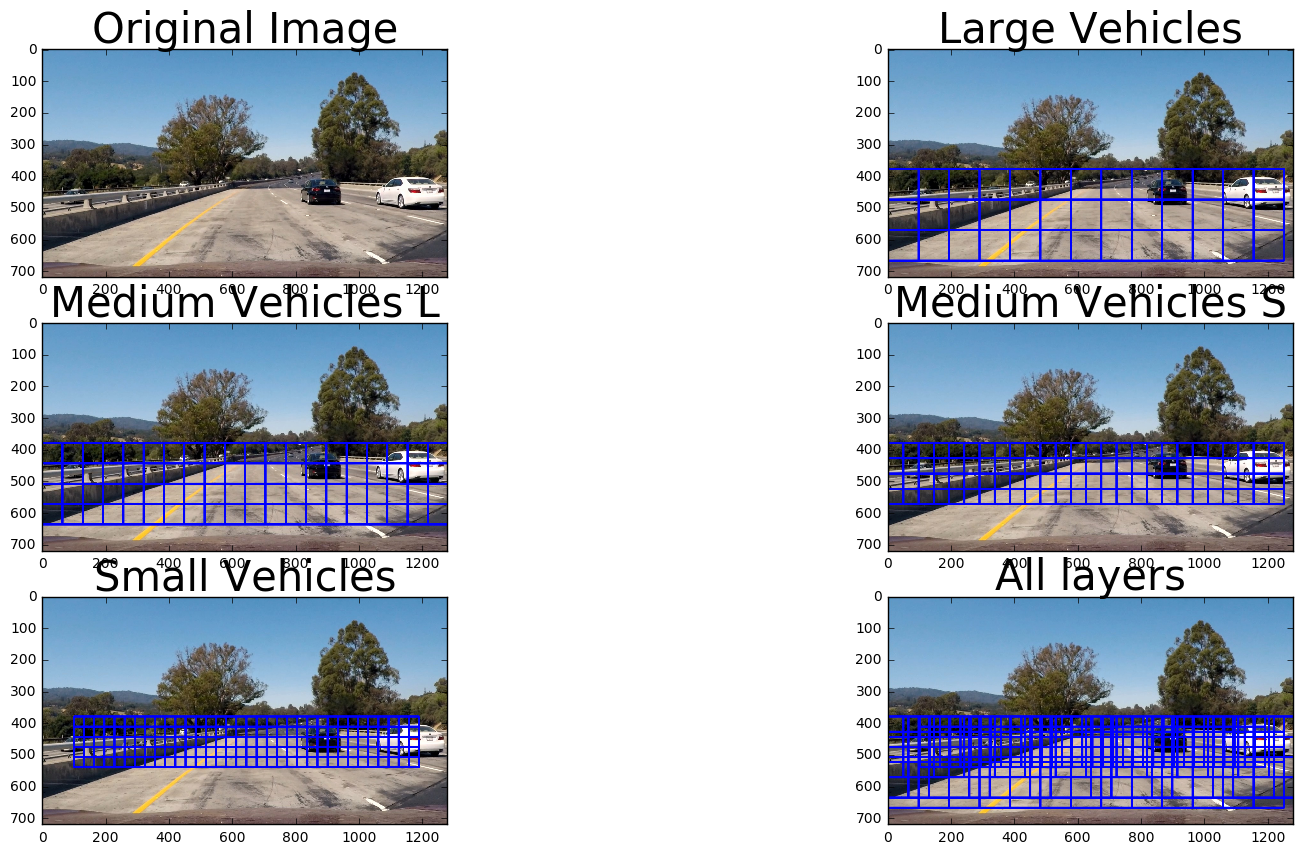

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image = mpimg.imread('../test_images/test1.jpg')
f, axarr = plt.subplots(3, 2, figsize=(20,10))

axarr[0, 0].imshow(image)
axarr[0, 0].set_title('Original Image', fontsize=30)

layer1 = slide_window(image, y_start_stop=[380, None], xy_window=(192,192))
l1img = draw_boxes(image, layer1)

axarr[0, 1].imshow(l1img)
axarr[0, 1].set_title('Large Vehicles', fontsize=30)

layer2 = slide_window(image, y_start_stop=[380, 650], xy_window=(128,128))
l2img = draw_boxes(image, layer2)

axarr[1, 0].imshow(l2img)
axarr[1, 0].set_title('Medium Vehicles L', fontsize=30)

layer3 = slide_window(image, y_start_stop=[380, 600], xy_window=(96,96))
l3img = draw_boxes(image, layer3)

axarr[1, 1].imshow(l3img)
axarr[1, 1].set_title('Medium Vehicles S', fontsize=30)

layer4 = slide_window(image, y_start_stop=[380, 550], x_start_stop=[100, 1200], xy_window=(64,64))
l4img = draw_boxes(image, layer4)

axarr[2, 0].imshow(l4img)
axarr[2, 0].set_title('Small Vehicles', fontsize=30)

layer1 = slide_window(image, y_start_stop=[380, None], xy_window=(192,192))
layer2 = slide_window(image, y_start_stop=[380, 650], xy_window=(128,128))
layer3 = slide_window(image, y_start_stop=[380, 600], xy_window=(96,96))
layer4 = slide_window(image, y_start_stop=[380, 550], x_start_stop=[100, 1200], xy_window=(64,64))
all_layers = layer1 + layer2 + layer3 + layer4
all_layer_img = draw_boxes(image, all_layers)

axarr[2, 1].imshow(all_layer_img)
axarr[2, 1].set_title('All layers', fontsize=30)

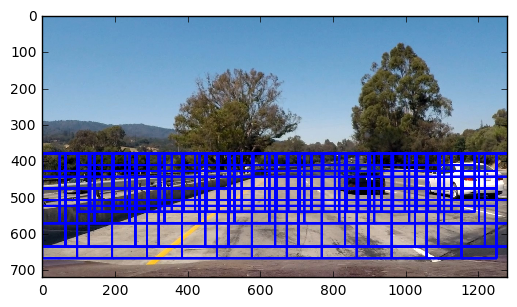

In [28]:
layer1 = slide_window(image, y_start_stop=[380, None], xy_window=(192,192))
layer2 = slide_window(image, y_start_stop=[380, 650], xy_window=(128,128))
layer3 = slide_window(image, y_start_stop=[380, 600], xy_window=(96,96))
layer4 = slide_window(image, y_start_stop=[380, 550], x_start_stop=[100, 1200], xy_window=(64,64))
all_layers = layer1 + layer2 + layer3 + layer4

all_img = draw_boxes(image, all_layers)
plt.imshow(all_img)

In [ ]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

found = search_windows(image, all_layers)